# Quantum Re-Uploading Unit (QRU) in PennyLane: a minimal, pedagogical demo

This notebook is a **community demo** built around a minimal **1‑qubit Quantum Re‑Uploading Unit (QRU)** implemented with PennyLane + PyTorch.

**What you’ll learn**
- What “re‑uploading” means in practice (data injected at each layer).
- How to train a QRU end‑to‑end with Torch autograd.
- How preprocessing (normalization / angle scaling) and simple constraints on parameters help stability.
- How to inspect the learned function and compare it to a target signal.

**Why this demo is minimal**
- 1 qubit, 1 observable output (⟨Z⟩), no entanglement.  
- The point is clarity and reproducibility, not maximum performance.

> If you want the full repo (noise experiments, qBraid/QASM export, etc.), see the repository this notebook belongs to.

## 0. Setup

If you run this locally, you’ll need:
- `pennylane`
- `torch`
- `numpy`, `matplotlib`

The repo provides `requirements.txt`. In a clean environment you can typically do:

```bash
pip install -r requirements.txt
```

Then run this notebook.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Use float64 for better stability with quantum gradients
torch.set_default_dtype(torch.float64)


## 1. The QRU idea in one diagram (conceptually)

A classical neural network layer typically does:

$$
h_{\ell+1} = \sigma(W_\ell h_\ell + b_\ell).
$$

A **re‑uploading** quantum model repeatedly injects the input $x$ at each layer $\ell$, for example through a data‑dependent rotation:

- trainable rotation(s) (parameters)
- **data rotation** (depends on $x$)
- repeat for depth $L$

In this demo, each layer applies:

$$
\text{RX}(\theta_{\ell,0})\; \text{RY}(\theta_{\ell,1}\, x)\; \text{RZ}(\theta_{\ell,2})
$$

and the model output is:

$$
f_\theta(x) = \langle Z \rangle \in [-1,1].
$$

We then train $\theta$ to approximate a target function.

## 2. Import the QRU implementation from the repo

This notebook assumes it lives **inside the repo**, so it can import from `qru/`.

The key components:
- `qru_template(inputs, weights)`: the circuit structure
- `make_qru_torchlayer(...)`: Torch `nn.Module` wrapper including:
  - input normalization (optional)
  - angle scaling (optional)
  - output mapping (optional)
  - parameter constraints helper `constrain_()`


In [2]:
from qru.qru_pennylane import make_qru_torchlayer

## 3. Regression task: learn a sine wave

We use a simple target function:

$$
y = \sin(x), \quad x \in [-\pi, \pi].
$$

This is a convenient sanity check:
- the function is smooth
- bounded
- and has a clear frequency content

> We keep the dataset small so the demo runs quickly on CPU.

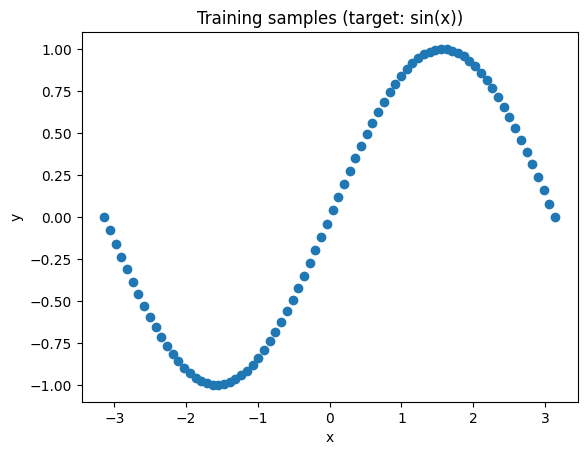

In [3]:
# Dataset
N_train = 80
N_test = 200

x_train = np.linspace(-np.pi, np.pi, N_train).reshape(-1, 1)
y_train = np.sin(x_train)

x_test = np.linspace(-np.pi, np.pi, N_test).reshape(-1, 1)
y_test = np.sin(x_test)

# Torch tensors
Xtr = torch.tensor(x_train)
Ytr = torch.tensor(y_train)
Xte = torch.tensor(x_test)
Yte = torch.tensor(y_test)

# Quick visualization
plt.figure()
plt.plot(x_train, y_train, marker="o", linestyle="None")
plt.title("Training samples (target: sin(x))")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 4. Build a minimal QRU model

We set:
- depth `L` (number of layers)
- `input_norm="identity"` because our x is already in radians
- `input_angle_scale="none"` for the same reason

You can try:
- increasing `L` for more expressivity
- using `zscore` + `pi` scaling when inputs are not already angles

We also use the built-in `constrain_()` after each optimizer step:
- wraps RX/RZ angles back to $(-\pi,\pi]$
- clamps the RY scale to a reasonable range

This avoids “parameter drift” (common in long training runs).


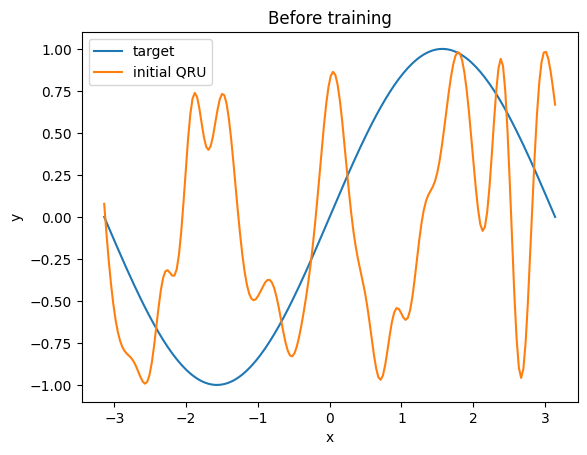

In [4]:
L = 6  # depth
model = make_qru_torchlayer(
    L=L,
    input_norm="identity",
    input_angle_scale="none",
    output_range=None,        # keep output in [-1, 1]
    ry_scale_max=3.0,         # clamp for stability (demo-friendly)
)

# Optimizer and loss
opt = torch.optim.Adam(model.parameters(), lr=0.08)
loss_fn = torch.nn.MSELoss()

def predict(model, X):
    model.eval()
    with torch.no_grad():
        return model(X)

# Baseline before training
y0 = predict(model, Xte).numpy()

plt.figure()
plt.plot(x_test, y_test, label="target")
plt.plot(x_test, y0, label="initial QRU")
plt.title("Before training")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 5. Train

We train with mean squared error:

$$
\mathcal{L}(\theta) = \frac{1}{N}\sum_i (f_\theta(x_i) - y_i)^2.
$$

Notes:
- We use full-batch training for simplicity.
- For larger datasets, you’d use a DataLoader and mini-batches.

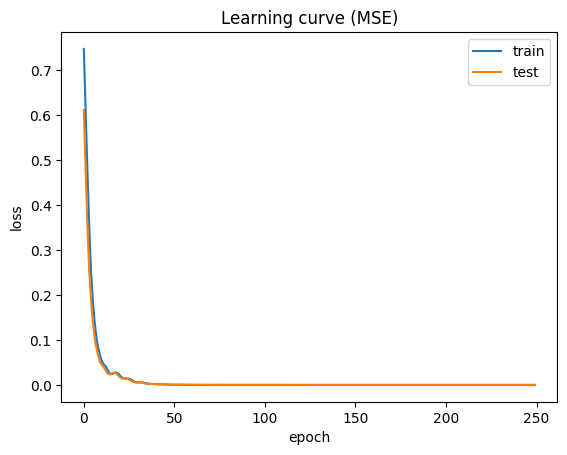

In [5]:
n_epochs = 250
train_losses = []
test_losses = []

for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    yhat = model(Xtr)
    loss = loss_fn(yhat, Ytr)
    loss.backward()
    opt.step()
    model.constrain_()  # keep angles/scales in a stable range

    train_losses.append(float(loss.detach().cpu().numpy()))
    # test loss
    yhat_te = model(Xte).detach()
    test_loss = loss_fn(yhat_te, Yte)
    test_losses.append(float(test_loss.cpu().numpy()))

# Plot learning curve
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.title("Learning curve (MSE)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

## 6. Results: learned function vs target

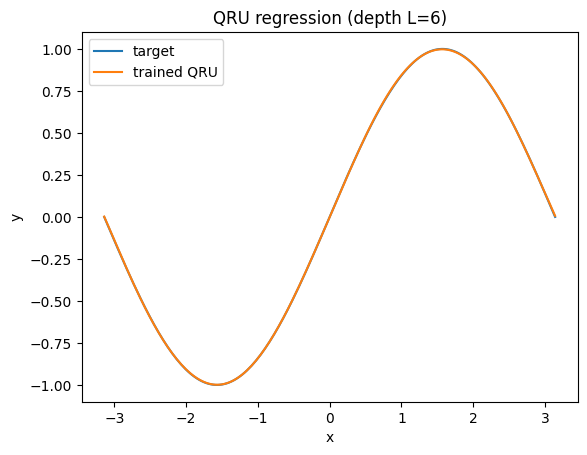

Test MSE: 2.6056131905664057e-06


In [6]:
y_pred = predict(model, Xte).numpy()

plt.figure()
plt.plot(x_test, y_test, label="target")
plt.plot(x_test, y_pred, label="trained QRU")
plt.title(f"QRU regression (depth L={L})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Quantitative summary
mse = float(np.mean((y_pred - y_test)**2))
print("Test MSE:", mse)

## 7. Inspect learned parameters (optional)

Each layer has 3 parameters:  
- RX angle $\theta_{\ell,0}$
- RY scale $\theta_{\ell,1}$ multiplying x  
- RZ angle $\theta_{\ell,2}$

Because we clamp / wrap, you should see:
- RX/RZ in roughly $(-\pi,\pi]$
- RY scales in [0, ry_scale_max]

weights shape: (6, 3) (L, 3)
RX angles   (min, max): -1.4982078912419414 3.123853116640868
RY scales   (min, max): 1.1320866174539213 2.9535453643372476
RZ angles   (min, max): -3.126128659581562 3.1275597440033147


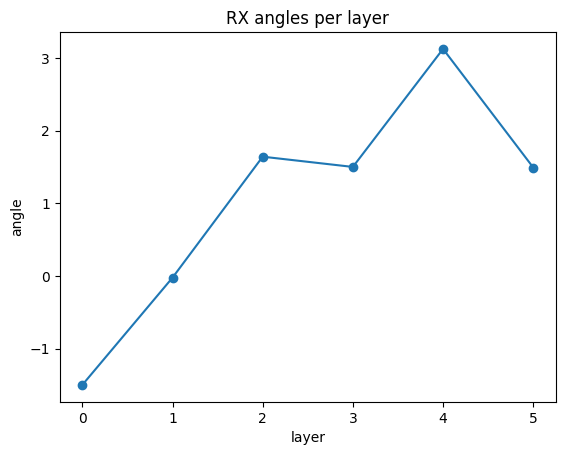

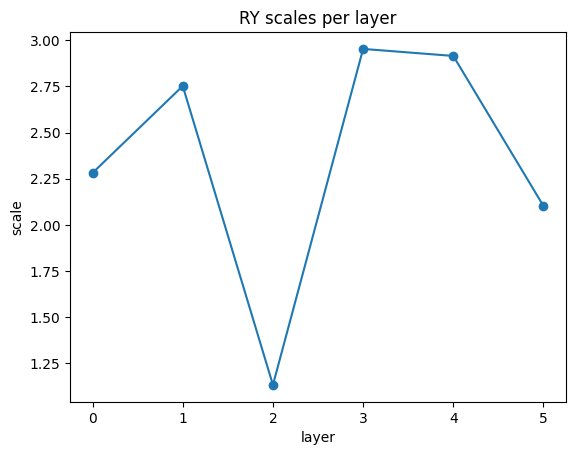

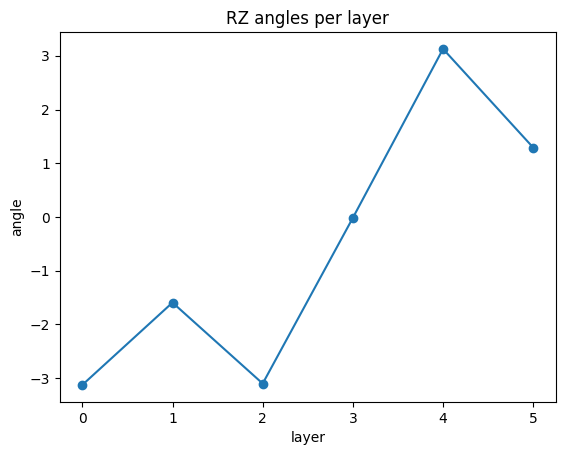

In [7]:
with torch.no_grad():
    W = model.layer.weights.detach().cpu().numpy()

print("weights shape:", W.shape, "(L, 3)")
print("RX angles   (min, max):", W[:,0].min(), W[:,0].max())
print("RY scales   (min, max):", W[:,1].min(), W[:,1].max())
print("RZ angles   (min, max):", W[:,2].min(), W[:,2].max())

# Simple plot of per-layer parameters
plt.figure()
plt.plot(W[:,0], marker="o")
plt.title("RX angles per layer")
plt.xlabel("layer")
plt.ylabel("angle")
plt.show()

plt.figure()
plt.plot(W[:,1], marker="o")
plt.title("RY scales per layer")
plt.xlabel("layer")
plt.ylabel("scale")
plt.show()

plt.figure()
plt.plot(W[:,2], marker="o")
plt.title("RZ angles per layer")
plt.xlabel("layer")
plt.ylabel("angle")
plt.show()

## 8. A tiny frequency peek (optional, demo-friendly)

Because the target is a single sine, it’s natural to ask:
> does the learned model capture the dominant frequency?

For a quick qualitative check, we can compare the FFT magnitudes of:
- target samples
- QRU output samples

This is **not** a rigorous Fourier analysis of the circuit’s expressivity, it’s just a simple “sanity lens” on the learned signal.

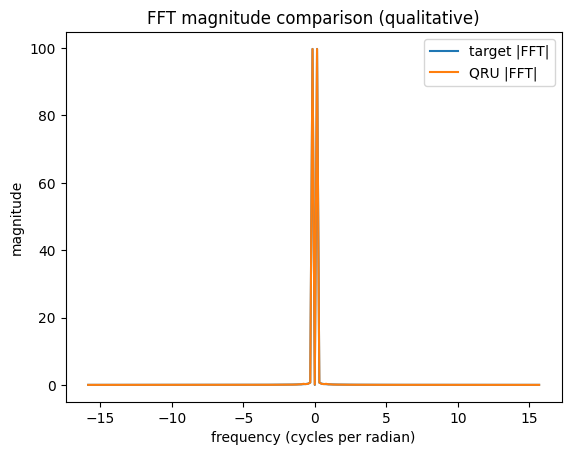

In [8]:
# Uniform grid already, so FFT is straightforward
target = y_test.squeeze()
pred = y_pred.squeeze()

# FFT magnitudes (centered)
T = np.fft.fftshift(np.fft.fft(target))
P = np.fft.fftshift(np.fft.fft(pred))
freq = np.fft.fftshift(np.fft.fftfreq(len(target), d=(x_test[1,0]-x_test[0,0])))

plt.figure()
plt.plot(freq, np.abs(T), label="target |FFT|")
plt.plot(freq, np.abs(P), label="QRU |FFT|")
plt.title("FFT magnitude comparison (qualitative)")
plt.xlabel("frequency (cycles per radian)")
plt.ylabel("magnitude")
plt.legend()
plt.show()

## 9. Suggested extensions (for readers)

If you want to explore further (all available in the repo examples):

1) **Input normalization + angle scaling**  
   Use `input_norm="zscore"` and `input_angle_scale="pi"` when x is not already an angle.

2) **Noisy training / evaluation**  
   Try the `default.mixed` device and add noise channels, then sweep noise strength.

3) **Classification head**  
   Use QRU output as a learned feature feeding a small classical head (logits + CrossEntropy).

4) **Hardware / QASM export**  
   Use the qBraid example to export the circuit and execute on a provider backend.